## imports / setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
import torch
from torch import optim, nn
import PIL 
import pydicom

from functools import partial, reduce
from enum import Enum

In [3]:
# helper function from the competition
import mask_functions

# helpers

In [4]:
def ls(p, re='*'):
    return [i for i in p.glob(re)]

In [5]:
def getImg(fpath):
    ds = pydicom.read_file( fpath) # read dicom image
    return ds.pixel_array, ds # get image array
    
def getMask(imgId, df, shape):
    """returns nd array mask"""
    df = df.loc[df['ImageId'] == imgId]
    rle = df['EncodedPixels'].tolist()[0].strip()

    mask = np.zeros([*shape])
    if not rle == '-1':
        mask = mask_functions.rle2mask(rle, *shape)
        mask = np.flip(mask, axis=0)
        mask = np.rot90(mask, -1)
    return mask

def getImageAndMask(fname, labels):
    imgf = fname 
    imgPath = str(imgf)
    imgId = imgf.stem
    img,_ = getImg( imgPath )
    mask = getMask(imgId, df=labels, shape=img.shape)
    return img, mask

In [6]:
def plot_multi(fn, size=[1,1], item_list=[]):
    fig, ax = plt.subplots(size[0],size[1], figsize=(40,60))
    print(type(ax))
    
    ax = ax.flatten()
    for idx, a in enumerate(ax):
        if not idx > (len(item_list)-1):
            item = item_list[idx]
            fn(a, item)
                 
def plot_xray_mask(a, item, df, show_mask=True):
    img, mask = getImageAndMask(item, labels=df)
    a.imshow(img, cmap=plt.cm.bone)
    # if mask
    if not np.all(mask == 0): 
        a.set_title('Pneumothorax Present')
        a.imshow(mask, alpha=0.3, cmap='Reds')

# Check out sample

In [7]:
# get sample data
path = Path('/home/ubuntu/code/siim-acr')

In [8]:
path

PosixPath('/home/ubuntu/code/siim-acr')

In [9]:
dataPath = path/'data'
labels = dataPath/'train-rle-sample.csv'

In [10]:
fnames = ls(dataPath, '*.dcm');
labelsdf = pd.read_csv(labels, names=['ImageId', 'EncodedPixels']); 

<class 'numpy.ndarray'>


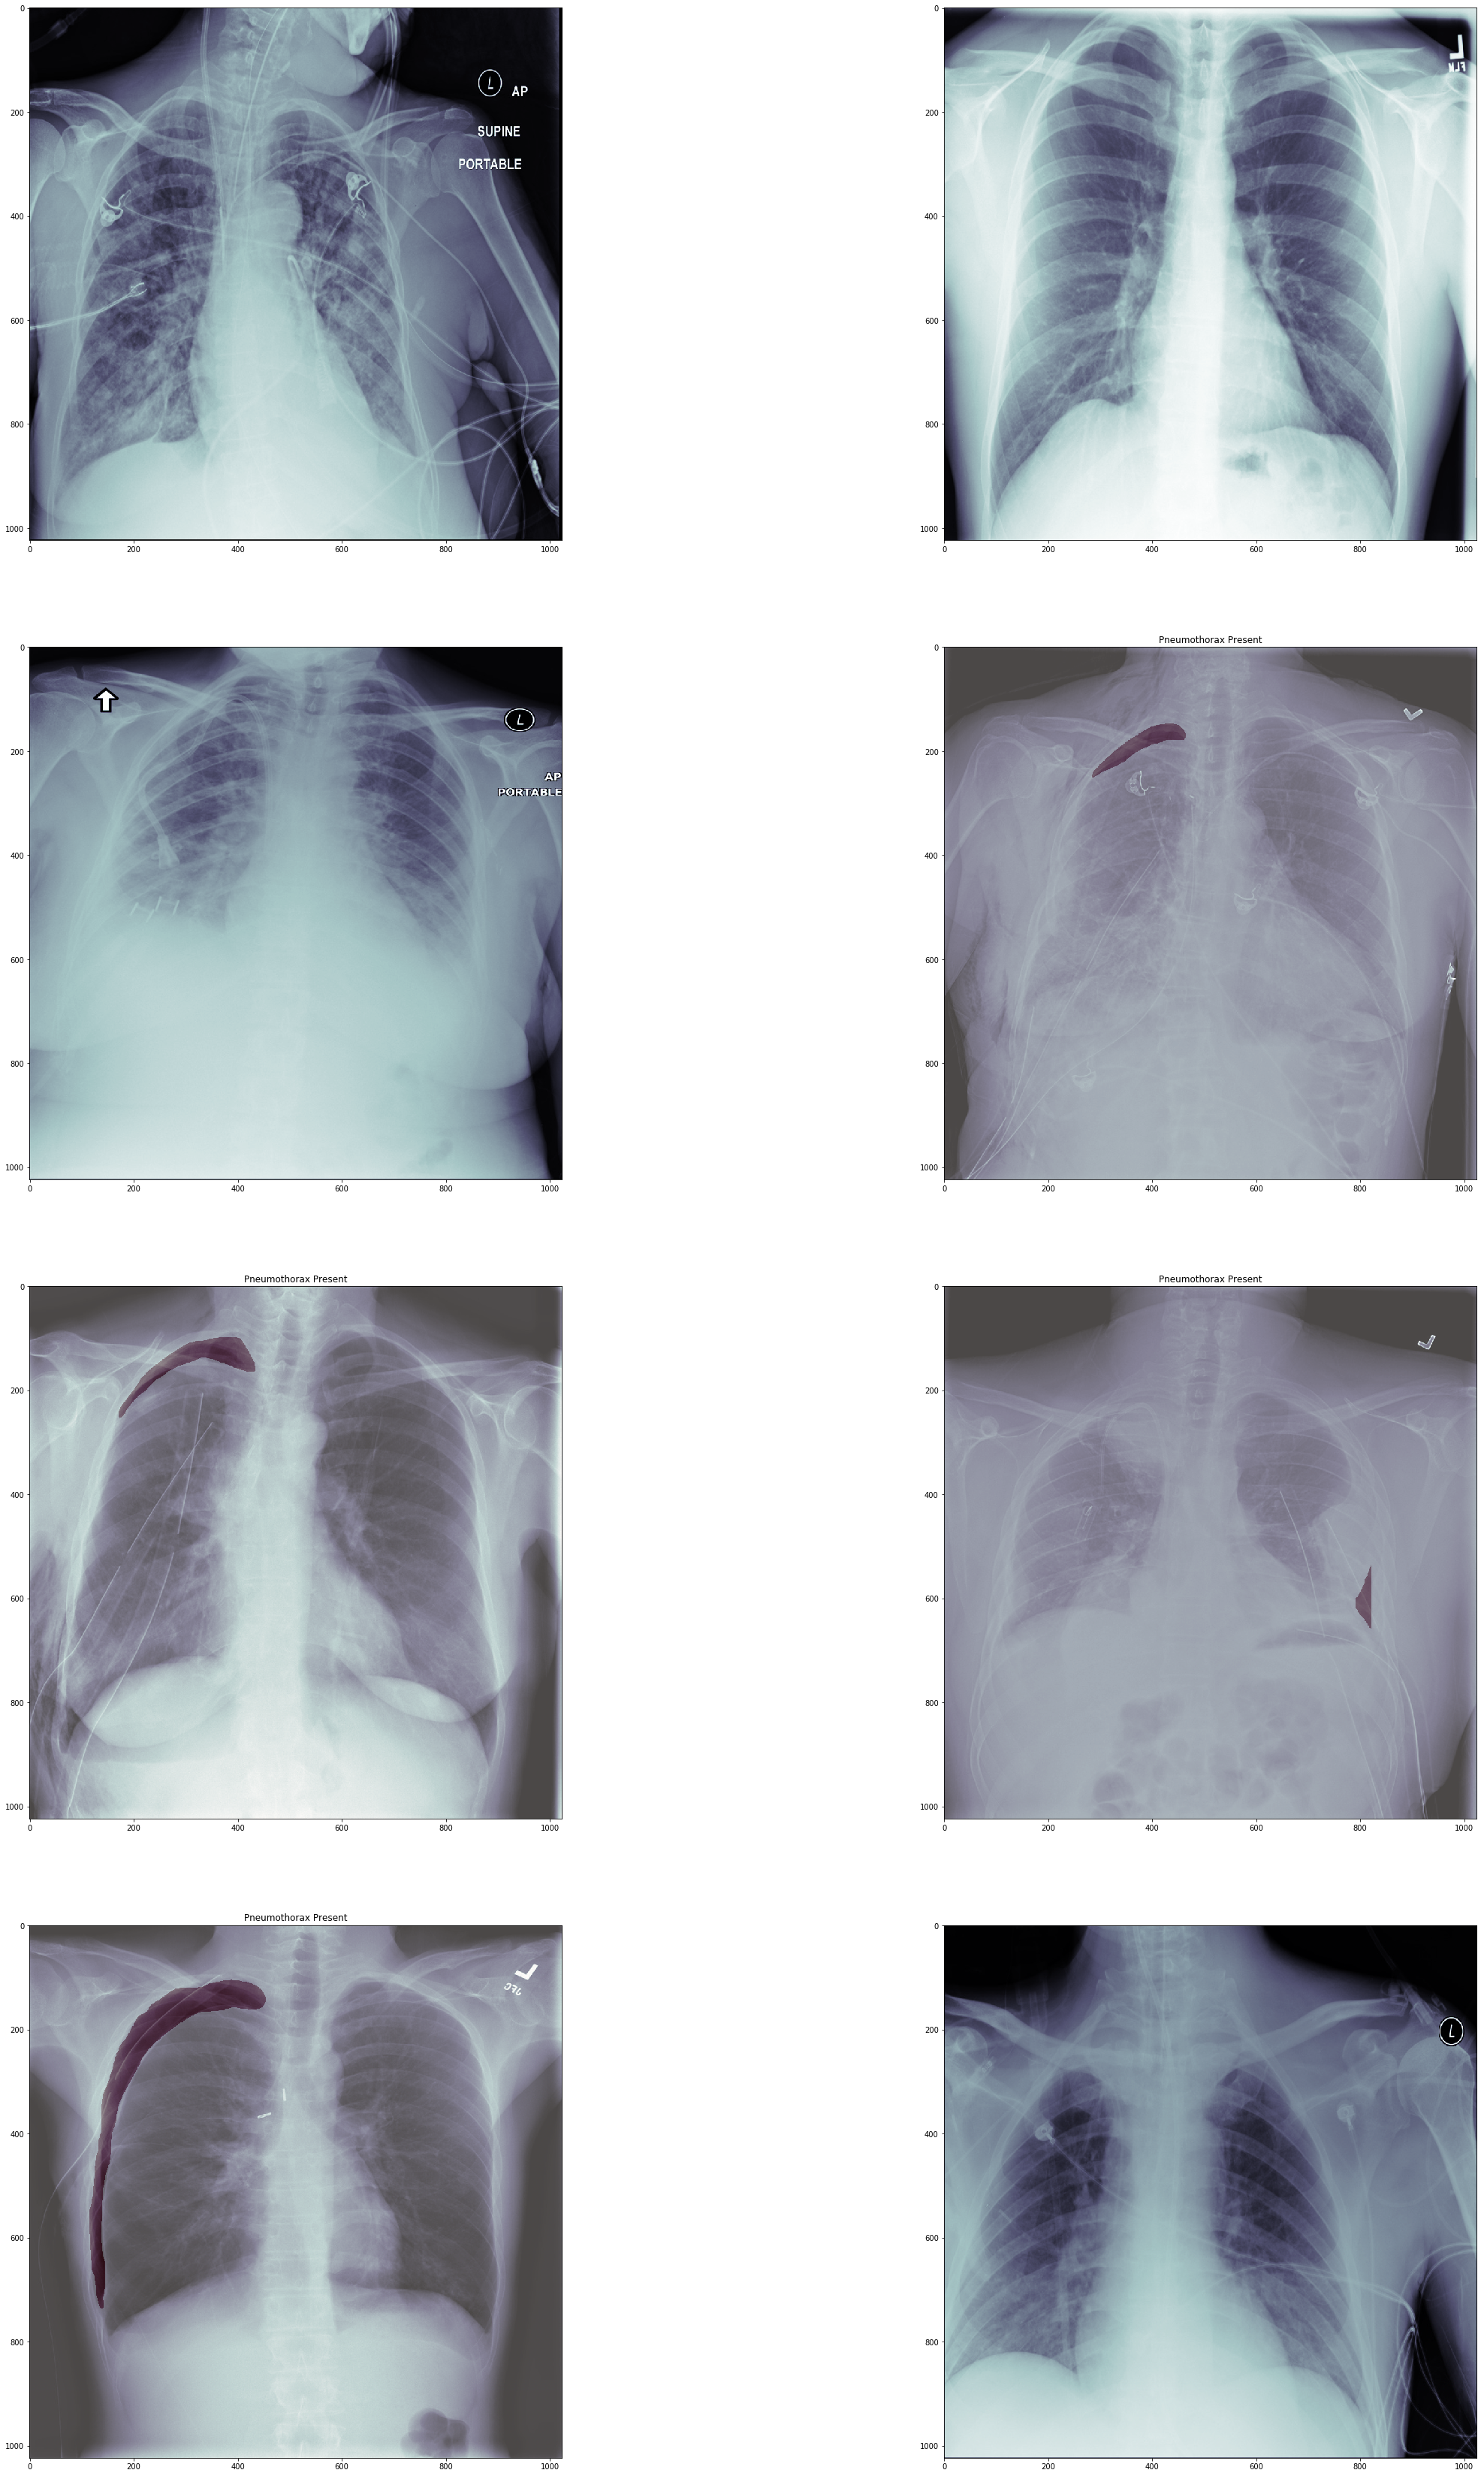

In [11]:
plot_samples = partial(plot_xray_mask, df=labelsdf, show_mask=True)
plot_multi(plot_samples, [4,2], item_list=fnames)

# Dataloader

In [12]:
from torch.utils.data import Dataset, dataloader

In [13]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [14]:
class Xray(Dataset):
    def __init__(self):
        
        x,y = zip(*[
            getImageAndMask(p, labelsdf) for p in fnames
        ])
        tmpx = torch.Tensor(x)
        m, h, w = tmpx.shape
        self.x = torch.Tensor(x).view(m, 1, h, w)
        self.y = torch.Tensor(y).view(m, 1, h, w)
        self.len = len(x)
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
        
    def __len__(self):
        return self.len
        
    
    

In [15]:
ds = Xray()

In [16]:
dl = dataloader.DataLoader(ds, batch_size=2, shuffle=True)

In [17]:
x, y = [i for i in iter(dl)][0]

In [18]:
x.shape, x.view([1,-1]).shape[1]

(torch.Size([2, 1, 1024, 1024]), 2097152)

In [20]:
 x[0].view([1,-1]).view([1,1024,1024]).dim()

3

In [23]:
x[0].view([1,-1]).dim()

2

# Model

In [24]:
from torch import nn

In [82]:
class Basic_NN(torch.nn.Module):
    def __init__(self, in_h, h_h, out_h):
        super().__init__()
        self.inp = nn.Linear(in_h,h_h)
        self.hid = nn.Linear(h_h,h_h)
        self.out = nn.Linear(h_h,out_h)
    
    def forward(self, x):
        out_shape = x.shape
        x = x.view([x.shape[0], 1,-1])
        a1 = F.relu( self.inp(x) )
        a2 = F.relu( self.hid(a1) )
        a3 = F.relu( self.out(a2) )
        return a3.view(out_shape)

# fit fn

In [69]:
to4dec = lambda a: np.around(a, decimals=4) if not a==None else None

listNumpy = lambda l: [x.item() for x in l]

sumLoss = lambda loss_list: np.sum(listNumpy(loss_list)) / len(loss_list)

caculate_metric = lambda metric: lambda predb, yb, : [ metric(predb, yb).item() for predb, yb in zip(predb, yb)]


def print_epoch_progress(epoch, train_loss=None, valid_loss=None, metrics=[]):
    metrics = [f"{key}: {to4dec(value)}" for key, value in metrics.items()]
    print(epoch, 'train loss: ', to4dec(train_loss),'valid loss: ', to4dec(valid_loss,), ' '.join(metrics))

class Learner(object):
    """
        Learner object holds model, optimizer and dataloaders
    """
    def __init__(self, model, opt, loss_fn, dls={}, metrics={}):
        self.model = model
        self.opt = opt
        self.loss_fn = loss_fn
        # assumes { trn: train_dl, val: valid_dl)
        self.data = dls
        self.metrics = metrics
#         self.schedule
        
        
    def descend_(self, xb, yb, is_valid=False):
        
        predb = self.model(xb)
        loss = self.loss_fn(predb, yb)

        if is_valid is not True:
            # cloze {
            loss.backward()
            self.opt.step()
            self.opt.zero_grad()
            # } cloze
        return loss, predb, yb,xb
    
    
    def fit_(self, epochs=1):
        for epoch in range(epochs):
            
             # training
            model.train()
            trn_losses,_,_,_ = zip(
                *[self.descend_(xb, yb) for xb, yb in self.data['trn'] ]
            )
            
            # validation
            validation_loss = None
            if self.data['val'] is not None:
                model.eval()
                with torch.no_grad():
                    val_losses,predb,yb,xb = zip(
                        *[self.descend_(xb, yb, is_valid=True) for xb, yb in self.data['val']]
                    )
                validation_loss = sumLoss(val_losses)
            
            training_loss = sumLoss(trn_losses)
            
            
            
            metrics = { 
                name:np.mean(caculate_metric(fn)(predb,yb)) for name, fn in self.metrics.items()
            }
#             = [ m for predb, yb in zip(predb, yb)]
    
#             print_epoch_progress(epoch+1, training_loss, validation_loss, {'accuracy': epoch_accuracy}) 
            print(epoch+1, training_loss, validation_loss, metrics)

In [70]:
import torch.nn.functional as F
loss_fn = torch.nn.MSELoss

In [84]:
input_h, hid_h =  x[0].view([1,-1]).shape[1], 10 

In [85]:
model = Basic_NN(input_h, hid_h, input_h)

In [86]:
# print the parameters in a model?
[i.shape for i in model.parameters()]

[torch.Size([10, 1048576]),
 torch.Size([10]),
 torch.Size([10, 10]),
 torch.Size([10]),
 torch.Size([1048576, 10]),
 torch.Size([1048576])]

In [74]:
x[0].shape

torch.Size([1024, 1024])

In [90]:
ypred = model(x)

In [76]:
loss_fn

torch.nn.modules.loss.MSELoss

# Prediction

In [96]:
x, y = [i for i in iter(dl)][2]
x = x[1]
y = y[1]

<class 'numpy.ndarray'>


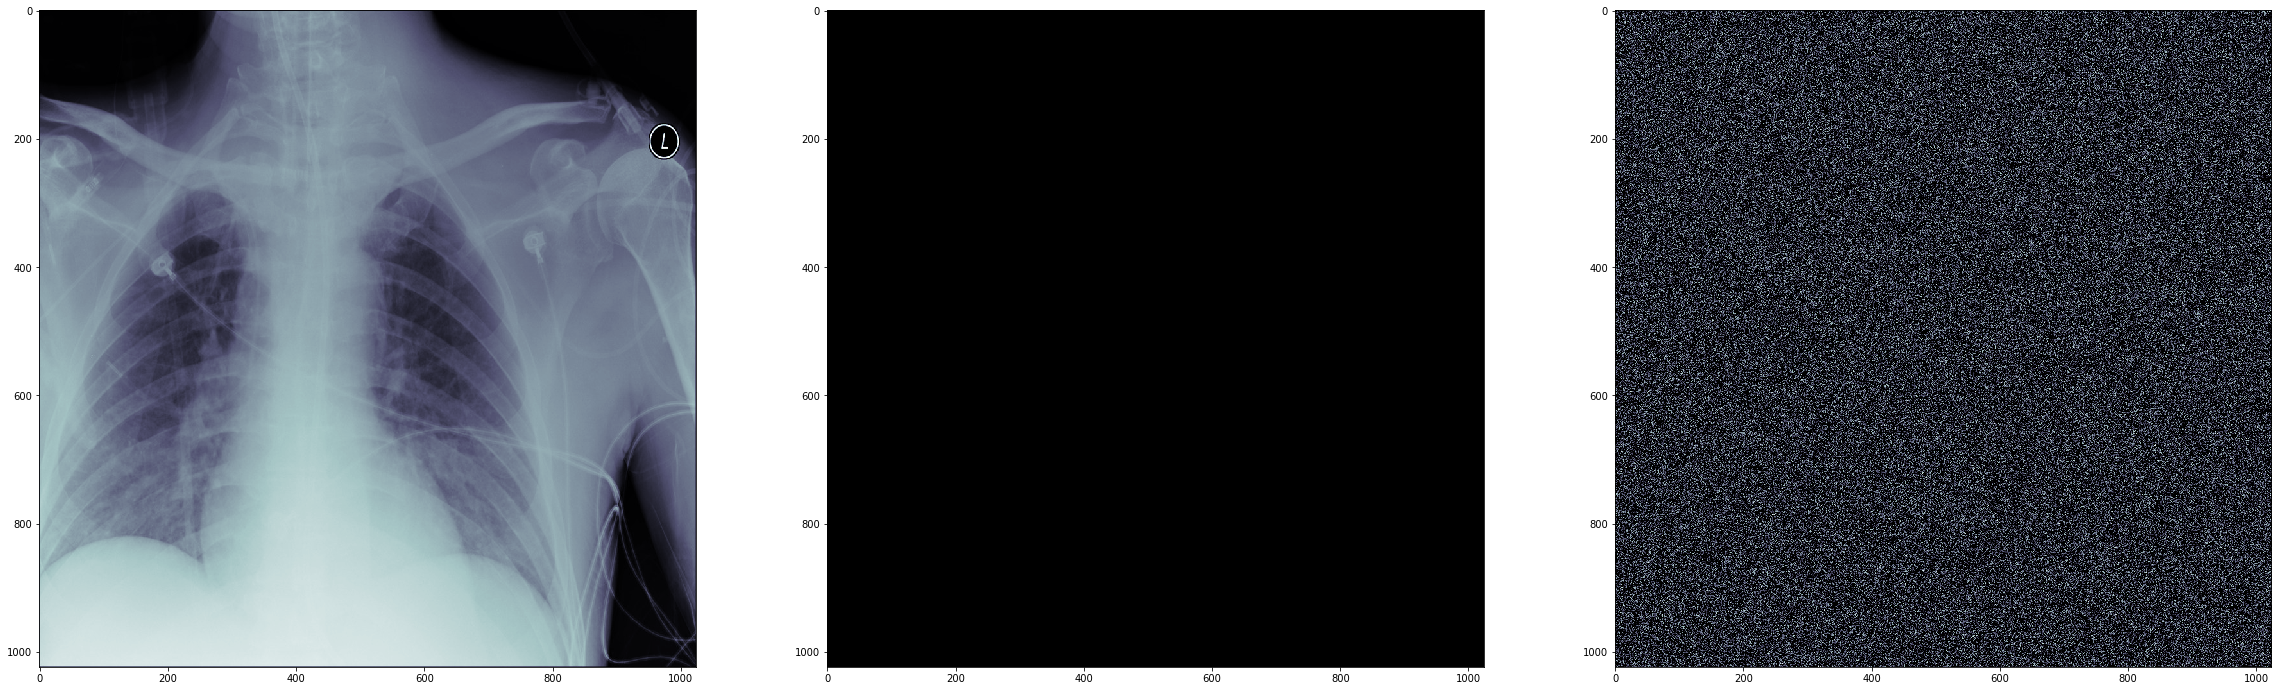

In [97]:
def plot_xray(a, img):
    a.imshow(img, cmap=plt.cm.bone)

detach = lambda ten: ten.detach().numpy()[0]
    
def plot_xyhat(arr):
    item_list =[ detach(x) for x in arr ]

    plot_multi(plot_xray, size=[1,3], item_list=item_list)

plot_xyhat([x,y,ypred])

In [98]:
opt = torch.optim.SGD(model.parameters(), lr=0.02)
learn = Learner(model, opt, loss_fn(), {'trn': dl, 'val': None})

In [99]:
learn.fit_(10)

1 299.259734550491 None {}
2 299.259621957317 None {}
3 299.25949631519615 None {}
4 299.25938735231756 None {}
5 299.2592524204403 None {}
6 299.2591247558594 None {}
7 299.2589942932129 None {}
8 299.25889188311993 None {}
9 299.2587287679315 None {}
10 299.2585906982422 None {}


# Unet 

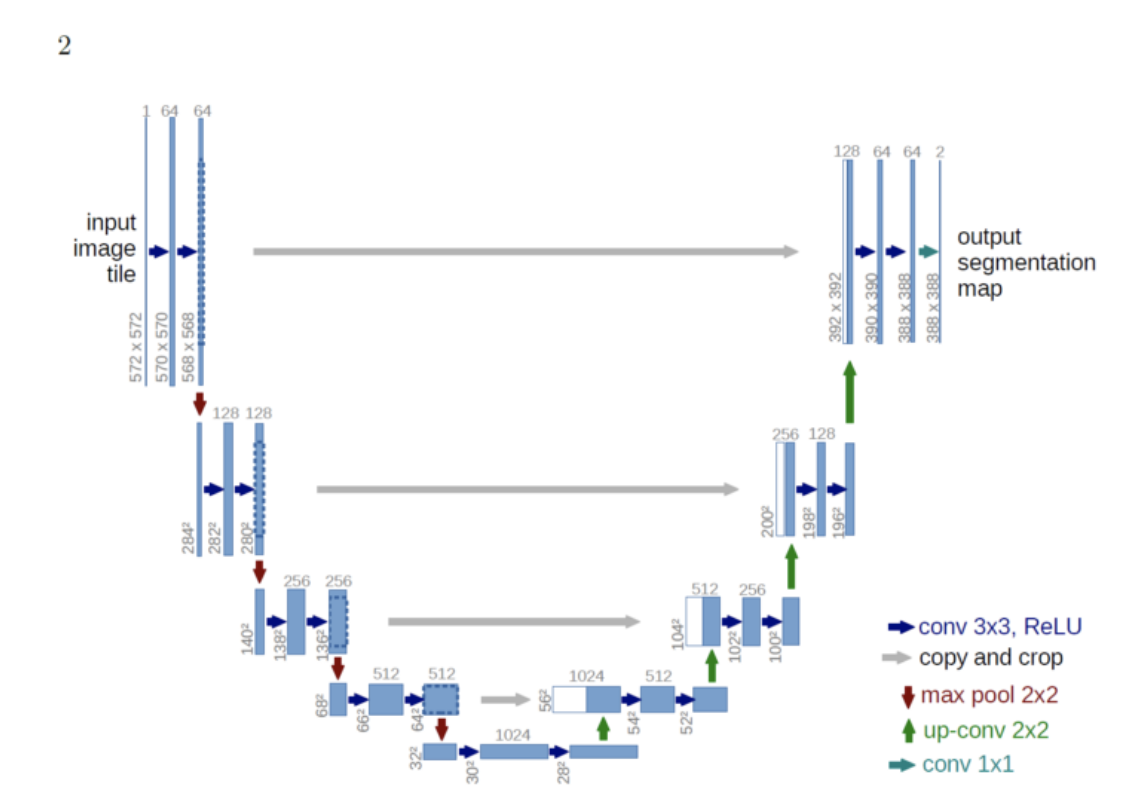

## encoder

In [100]:
class ResBlock(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.c1 = nn.Conv2d(ni, nf, kernel_size=3, stride=1, padding=1)
        self.c2 = nn.Conv2d(ni, nf, kernel_size=3, stride=1, padding=1)
        
    def forward(self, x):
        a1 = F.relu(self.c1(x))
        a2 = F.relu(self.c2(x))
        return torch.add(a2, x)
        

In [101]:
resb = ResBlock(1, 16)

yp = resb(x[None])
assert(yp.shape == (1,16,1024,1024))

In [102]:
def conv2d(ni, nf, s): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
def conv_layer(ni, nf, s=2, p=0.5): 
    return nn.Sequential(
    conv2d(ni, nf, s),
    nn.BatchNorm2d(nf),
    nn.Dropout3d(p),
    nn.ReLU()
)

class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x.view(x.size(0), -1)

In [103]:
cnn = nn.Sequential(
    conv_layer(1, 16, 2, 0.5), # 1024*1024
    conv_layer(16, 32, 2, 0.5),
    ResBlock(32, 32),
    conv_layer(32, 64, 2, 0.5),
    conv_layer(64, 128, 2, 0.5),
    ResBlock(128, 128),
    conv_layer(128, 256, 2, 0.5), 
    conv_layer(256, 512, 2, 0.5), # 16*16
    ResBlock(512, 512),
)

In [104]:
cnn[0]

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Dropout3d(p=0.5)
  (3): ReLU()
)

In [105]:
yp = cnn(x[None])
yp.shape
assert(yp.shape == (1, 512, 16,16))

In [106]:
t = 0
for l in cnn.parameters():
    t += l.view(1, -1).shape[1]
t

6607776

## hook a brother up

In [107]:

def hookCallback(self, input, output, idx):
    # input is a tuple of packed inputs
    # output is a Tensor. output.data is the Tensor we are interested
    print('Inside ' + self.__class__.__name__  +' forward')
    print(idx)
    print('')
    print('input: ', type(input))
    print('input[0]: ', type(input[0]))
    print('output: ', type(output))
    print('')
    print('input size:', input[0].size())
    print('output size:', output.data.size())
    print('output norm:', output.data.norm())


In [108]:
skips = [0, 2, 5, 8]

for i in skips:
    cnn[i].register_forward_hook(partial(hookCallback, idx=i))

In [109]:
_ = cnn(x[None])

Inside Sequential forward
0

input:  <class 'tuple'>
input[0]:  <class 'torch.Tensor'>
output:  <class 'torch.Tensor'>

input size: torch.Size([1, 1, 1024, 1024])
output size: torch.Size([1, 16, 512, 512])
output norm: tensor(899.5173)
Inside ResBlock forward
2

input:  <class 'tuple'>
input[0]:  <class 'torch.Tensor'>
output:  <class 'torch.Tensor'>

input size: torch.Size([1, 32, 256, 256])
output size: torch.Size([1, 32, 256, 256])
output norm: tensor(982.5888)
Inside ResBlock forward
5

input:  <class 'tuple'>
input[0]:  <class 'torch.Tensor'>
output:  <class 'torch.Tensor'>

input size: torch.Size([1, 128, 64, 64])
output size: torch.Size([1, 128, 64, 64])
output norm: tensor(512.0217)
Inside ResBlock forward
8

input:  <class 'tuple'>
input[0]:  <class 'torch.Tensor'>
output:  <class 'torch.Tensor'>

input size: torch.Size([1, 512, 16, 16])
output size: torch.Size([1, 512, 16, 16])
output norm: tensor(232.5602)


In [110]:
NormType = Enum('NormType', 'Batch BatchZero Weight Spectral')

In [111]:
# steal fastai deconvolution pixel shuffle

def icnr(x, scale=2, init=nn.init.kaiming_normal_):
    "ICNR init of `x`, with `scale` and `init` function."
    ni,nf,h,w = x.shape
    ni2 = int(ni/(scale**2))
    k = init(torch.zeros([ni2,nf,h,w])).transpose(0, 1)
    k = k.contiguous().view(ni2, nf, -1)
    k = k.repeat(1, 1, scale**2)
    k = k.contiguous().view([nf,ni,h,w]).transpose(0, 1)
    x.data.copy_(k)

class PixelShuffle_ICNR(nn.Module):
    "Upsample by `scale` from `ni` filters to `nf` (default `ni`), using `nn.PixelShuffle`, `icnr` init, and `weight_norm`."
    def __init__(self, ni:int, nf:int=None, scale:int=2, blur:bool=False, norm_type=NormType.Weight, leaky:float=None):
        nf = ifnone(nf, ni)
        self.conv = conv_layer(ni, nf*(scale**2), ks=1, norm_type=norm_type, use_activ=False)
        icnr(self.conv[0].weight)
        self.shuf = nn.PixelShuffle(scale)
        # Blurring over (h*w) kernel
        # "Super-Resolution using Convolutional Neural Networks without Any Checkerboard Artifacts"
        # - https://arxiv.org/abs/1806.02658
        self.pad = nn.ReplicationPad2d((1,0,1,0))
        self.blur = nn.AvgPool2d(2, stride=1)
        self.relu = relu(True, leaky=leaky)

    def forward(self,x):
        x = self.shuf(self.relu(self.conv(x)))
        return self.blur(self.pad(x)) if self.blur else x


In [112]:
# just use this deconvolution first
nn.ConvTranspose2d

torch.nn.modules.conv.ConvTranspose2d

In [113]:
def deconv2d(ni, nf, s): return nn.ConvTranspose2d(ni, nf, kernel_size=3, stride=2, padding=1, output_padding=1)
def deconv_layer(ni, nf, s=2, p=0.5): 
    return nn.Sequential(
    deconv2d(ni, nf, s),
    nn.BatchNorm2d(nf),
    nn.Dropout3d(p),
    nn.ReLU()
)

In [114]:
layer = nn.Sequential(
    nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.BatchNorm2d(256),
    nn.Dropout3d(0.1),
    nn.ReLU()
)

input_x = torch.rand([1, 512, 16, 16])

out_a = layer(input_x)

print(input_x.shape, out_a.shape)

torch.Size([1, 512, 16, 16]) torch.Size([1, 256, 32, 32])


In [115]:
# accepts a skip connection hook_a and 
class unet_block(nn.Module):
    def __init__(self, hook):
        self.hook = hook
        
        
    def forward(self, x):  
        hook_a = self.hook
        
        
        return x

In [116]:
class unet(nn.Module):
    def __init__(self, enc): 
        self.enc = enc # expects nn.seq
        self.hooks = [ self.enc[i].register_forward_hook(self.hook_a) for i in [0, 2, 5, 8]]
        
#     def hook_a(self, input, output):
    
    def forward(self, x): 
        return x

In [117]:
class unet_simple(nn.Module):
    def __init__(self):
        super().__init__()
        
        # encoder
#         self.rin0 = ResBlock(1, 1) # 1024
        self.cin1 = conv_layer(1, 16, 2, 0.5) # 1024**2 -> 512**2
        self.cin2 = conv_layer(16, 32, 2, 0.5) # 512**2 -> 256**2
        self.rin1 = ResBlock(32, 32) # 256 
        self.cin3 = conv_layer(32, 64, 2, 0.5) # 256**2 -> 128**2
        self.cin4 = conv_layer(64, 128, 2, 0.5) # 128**2 -> 64**2
        self.rin2 = ResBlock(128, 128) # 64
        self.cin5 = conv_layer(128, 256, 2, 0.5) # 64**2 -> 32**2
        self.cin6 = conv_layer(256, 512, 2, 0.5) # 32**2 -> 16**2
        self.rin3 = ResBlock(512, 512)
        
        # decoder
        self.dcout1 = deconv_layer(512, 256, 2, 0.5) # 16**2 -> 32**2
        self.dcout2 = deconv_layer(256, 128, 2, 0.5) # 32**2 -> 64**2
        self.drout1 = ResBlock(256, 256) # 64
        # skip
        self.dcout3 = deconv_layer(256, 64, 2, 0.5) # 64**2 -> 128**2
        self.dcout4 = deconv_layer(64, 32, 2, 0.5) # 128**2 -> 256**2
        self.drout2 = ResBlock(64, 64) # 256
        # skip
        self.dcout5 = deconv_layer(64, 32, 2, 0.5) # 256**2 -> 512**2
        self.dcout6 = deconv_layer(32, 1, 2, 0.5) # 512**2 -> 1024**2
#         self.drout3 = ResBlock(16, 16) # 1024
        # skip with input + a
        
        
    def forward(self, x):
        
        # downsampling path
#         a0 = self.rin0(x)
        # skip + x
        a1 = self.cin1(x)
        a2 = self.cin2(a1)
        a3 = self.rin1(a2)
        # skip
        a4 = self.cin3(a3)
        a5 = self.cin4(a4)
        a6 = self.rin2(a5) 
        # skip
        a7 = self.cin5(a6)
        a8 = self.cin6(a7)
        a9 = self.rin3(a8) 
        
        
        # upsample path

        a10 = self.dcout1(a9)
        a11 = self.dcout2(a10)
        print([a.shape for a in [a9, a10, a11]])
        
        print(a11.shape, a6.shape)
        skip_a_64 = torch.cat((a11, a6), 1)
        a12 = self.drout1(skip_a_64)
        
        a13 = self.dcout3(a12)
        a14 = self.dcout4(a13)
        
        print(a14.shape, a3.shape)
        skip_a_256 = torch.cat((a14, a3), 1)
        a15 = self.drout2(skip_a_256)
        
        a16 = self.dcout5(a15)
        a17 = self.dcout6(a16)
        
#         skip_a_1024 = torch.cat((a17, a0, x), 1)
#         a15 = self.drout3(skip_a_256)
        
        return a17

In [118]:
model = unet_simple()

In [119]:
# model

In [123]:
x.shape

torch.Size([1, 1024, 1024])

In [124]:
ypred = model(x[None])

[torch.Size([1, 512, 16, 16]), torch.Size([1, 256, 32, 32]), torch.Size([1, 128, 64, 64])]
torch.Size([1, 128, 64, 64]) torch.Size([1, 128, 64, 64])
torch.Size([1, 32, 256, 256]) torch.Size([1, 32, 256, 256])


In [125]:
for i in [x,y,ypred]: print(i.shape)

torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([1, 1, 1024, 1024])


In [1]:
plot_xyhat([x,y,ypred[0]])

NameError: name 'plot_xyhat' is not defined

In [127]:
opt = torch.optim.SGD(model.parameters(), lr=0.02)
learn = Learner(model, opt, loss_fn(), {'trn': dl, 'val': None})

In [ ]:
learn.fit_(1)

[torch.Size([2, 512, 16, 16]), torch.Size([2, 256, 32, 32]), torch.Size([2, 128, 64, 64])]
torch.Size([2, 128, 64, 64]) torch.Size([2, 128, 64, 64])
torch.Size([2, 32, 256, 256]) torch.Size([2, 32, 256, 256])
